## Introduction
For this project, we're going to review the Student Performance dataset from https://archive.ics.uci.edu/dataset/320/student+performance
We are going to attempt to predict or classify student final grades using as many of the features in the dataset as
possible in a bid to determine which of these features are the most useful, and which algorithm provides the best
predictions and/or classifications.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline

## Import data set
Import the data set. Review the data types

In [2]:
file_path = 'student-mat.csv'
data = pd.read_csv(file_path, sep=';')
print("Column Types:")
print(data.dtypes)
print("Data Info:")
print(data.info())

Column Types:
school        object
sex           object
age            int64
address       object
famsize       object
Pstatus       object
Medu           int64
Fedu           int64
Mjob          object
Fjob          object
reason        object
guardian      object
traveltime     int64
studytime      int64
failures       int64
schoolsup     object
famsup        object
paid          object
activities    object
nursery       object
higher        object
internet      object
romantic      object
famrel         int64
freetime       int64
goout          int64
Dalc           int64
Walc           int64
health         int64
absences       int64
G1             int64
G2             int64
G3             int64
dtype: object
Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2 

## Inspect the data
Take a look at the first 5 rows

In [3]:
print(data.head())

  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        6   5   6   6  
1      5        3      3     1     1      3        4   5   5   6  
2      4        3      2     2     3      3       10   7   8  10  
3      3        2      2     1     1      5        2  15  14  15  
4      4        3      2     1     2      5        4   6  10  10  

[5 rows x 33 columns]


## Inspect unique values
Check for unique values for all object columns

In [4]:
for col in ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian',
            'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']:
    print(f"Unique values in {col}: {data[col].unique()}")

Unique values in school: ['GP' 'MS']
Unique values in sex: ['F' 'M']
Unique values in address: ['U' 'R']
Unique values in famsize: ['GT3' 'LE3']
Unique values in Pstatus: ['A' 'T']
Unique values in Mjob: ['at_home' 'health' 'other' 'services' 'teacher']
Unique values in Fjob: ['teacher' 'other' 'services' 'health' 'at_home']
Unique values in reason: ['course' 'other' 'home' 'reputation']
Unique values in guardian: ['mother' 'father' 'other']
Unique values in schoolsup: ['yes' 'no']
Unique values in famsup: ['no' 'yes']
Unique values in paid: ['no' 'yes']
Unique values in activities: ['no' 'yes']
Unique values in nursery: ['yes' 'no']
Unique values in higher: ['yes' 'no']
Unique values in internet: ['no' 'yes']
Unique values in romantic: ['no' 'yes']


## Include column for classification
Add a 'Performance' column to classify a grade as Pass or Fail

In [5]:
tmp_data = data.copy()
tmp_data['Performance'] = tmp_data['G3'].apply(lambda x: 1 if x >= 10 else 0)

## Ensure all columns are numerical
Map non-numerical data columns to numerical

In [6]:
binary_columns = ['schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
for col in binary_columns:
    tmp_data[col] = tmp_data[col].map({'yes': 1, 'no': 0})

# Map columns to integers
tmp_data['sex'] = tmp_data['sex'].map({'M': 0, 'F': 1})

tmp_data['Pstatus'] = tmp_data['Pstatus'].map({'T': 1, 'A': 0})

tmp_data['school'] = tmp_data['school'].map({'GP': 0, 'MS': 1})

from sklearn.preprocessing import LabelEncoder
label_columns = ['address', 'famsize', 'Mjob', 'Fjob', 'reason', 'guardian']
le = LabelEncoder()
for col in label_columns:
    tmp_data[col] = le.fit_transform(tmp_data[col])

print(tmp_data.head())
print(tmp_data.dtypes)

   school  sex  age  address  famsize  Pstatus  Medu  Fedu  Mjob  Fjob  ...  \
0       0    1   18        1        0        0     4     4     0     4  ...   
1       0    1   17        1        0        1     1     1     0     2  ...   
2       0    1   15        1        1        1     1     1     0     2  ...   
3       0    1   15        1        0        1     4     2     1     3  ...   
4       0    1   16        1        0        1     3     3     2     2  ...   

   freetime  goout  Dalc  Walc  health  absences  G1  G2  G3  Performance  
0         3      4     1     1       3         6   5   6   6            0  
1         3      3     1     1       3         4   5   5   6            0  
2         3      2     2     3       3        10   7   8  10            1  
3         2      2     1     1       5         2  15  14  15            1  
4         3      2     1     2       5         4   6  10  10            1  

[5 rows x 34 columns]
school         int64
sex            int64
age 

## Visually inspect for any correlation(s)
View correlation matrices for features

Correlation Matrix:
                  sex       age  studytime  traveltime  activities   nursery  \
sex          1.000000  0.028606   0.306268   -0.059722   -0.099833  0.008203   
age          0.028606  1.000000  -0.004140    0.070641   -0.103063 -0.086632   
studytime    0.306268 -0.004140   1.000000   -0.100909    0.089877  0.081325   
traveltime  -0.059722  0.070641  -0.100909    1.000000   -0.007766 -0.033338   
activities  -0.099833 -0.103063   0.089877   -0.007766    1.000000  0.002731   
nursery      0.008203 -0.086632   0.081325   -0.033338    0.002731  1.000000   
higher       0.151056 -0.209081   0.175081   -0.083508    0.096484  0.054303   
romantic     0.102023  0.164669   0.053285    0.021962    0.019651  0.027495   
internet    -0.044113 -0.112094   0.059422   -0.111302    0.048663  0.007830   
freetime    -0.238744  0.016434  -0.143198   -0.017025    0.089728 -0.024696   
goout       -0.075897  0.126964  -0.063904    0.028540    0.046088  0.004612   
Dalc        -0.26817

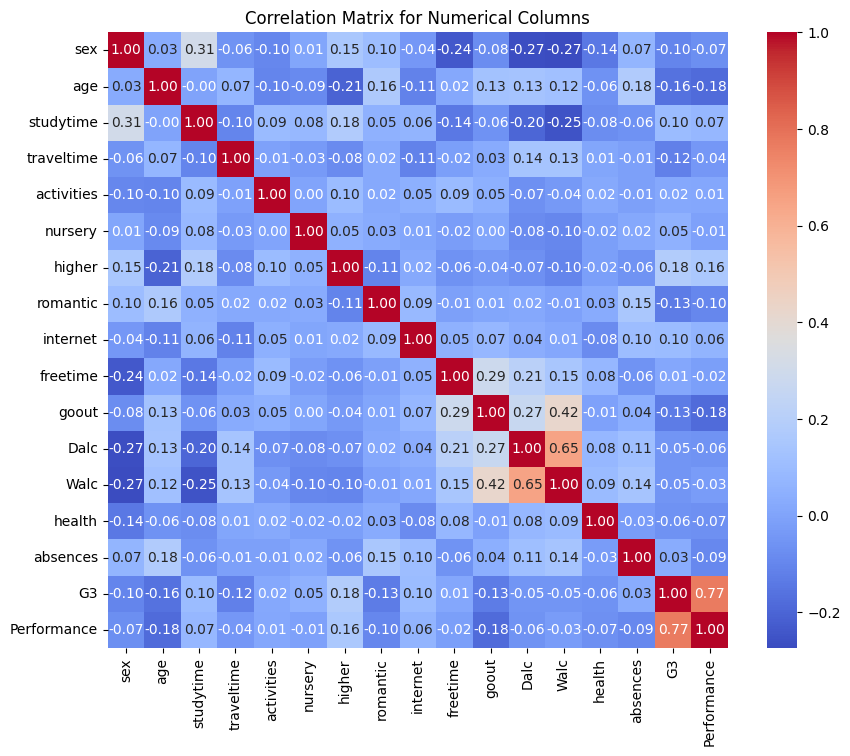

In [7]:
student_cols = [
    'sex', 'age', 'studytime', 'traveltime', 'activities',
    'nursery', 'higher', 'romantic', 'internet', 'freetime',
    'goout', 'Dalc', 'Walc', 'health', 'absences', 'G3', 'Performance'
]
student_data = tmp_data[student_cols]

correlation_matrix = student_data.corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for Numerical Columns')
plt.show()

Correlation Matrix:
              address   famsize   Pstatus      Medu      Fedu      Mjob  \
address      1.000000  0.072472 -0.042572  0.138804  0.072178  0.108818   
famsize      0.072472  1.000000 -0.149612 -0.043068 -0.058879  0.071386   
Pstatus     -0.042572 -0.149612  1.000000 -0.123565 -0.088730 -0.054476   
Medu         0.138804 -0.043068 -0.123565  1.000000  0.623455  0.454805   
Fedu         0.072178 -0.058879 -0.088730  0.623455  1.000000  0.243327   
Mjob         0.108818  0.071386 -0.054476  0.454805  0.243327  1.000000   
Fjob        -0.001911 -0.084448  0.033892  0.157920  0.200169  0.196758   
guardian    -0.044512 -0.002718 -0.108715 -0.023918 -0.133644  0.014787   
traveltime  -0.328096  0.063493  0.028265 -0.171639 -0.158194 -0.109752   
famsup       0.023903 -0.112893  0.019067  0.183727  0.185496  0.050667   
internet     0.216842  0.000720  0.070074  0.201463  0.127507  0.216969   
famrel       0.014258 -0.022776  0.025179 -0.003914 -0.001370  0.038584   
G3   

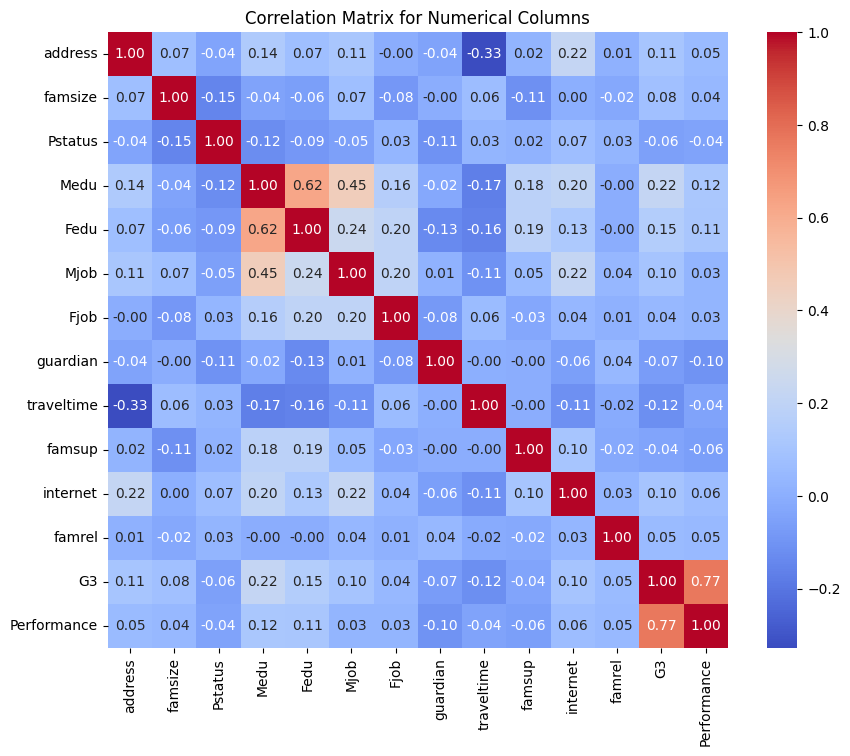

In [8]:
family_cols = [
    'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob',
    'guardian', 'traveltime', 'famsup', 'internet', 'famrel', 'G3', 'Performance'
]
family_data = tmp_data[family_cols]

correlation_matrix = family_data.corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for Numerical Columns')
plt.show()

Correlation Matrix:
                 paid  schoolsup  failures    reason        G3  Performance
paid         1.000000  -0.020753 -0.188039  0.133559  0.101996     0.092665
schoolsup   -0.020753   1.000000 -0.000437  0.018516 -0.082788    -0.099860
failures    -0.188039  -0.000437  1.000000 -0.067094 -0.360415    -0.337731
reason       0.133559   0.018516 -0.067094  1.000000  0.121994     0.099300
G3           0.101996  -0.082788 -0.360415  0.121994  1.000000     0.770042
Performance  0.092665  -0.099860 -0.337731  0.099300  0.770042     1.000000


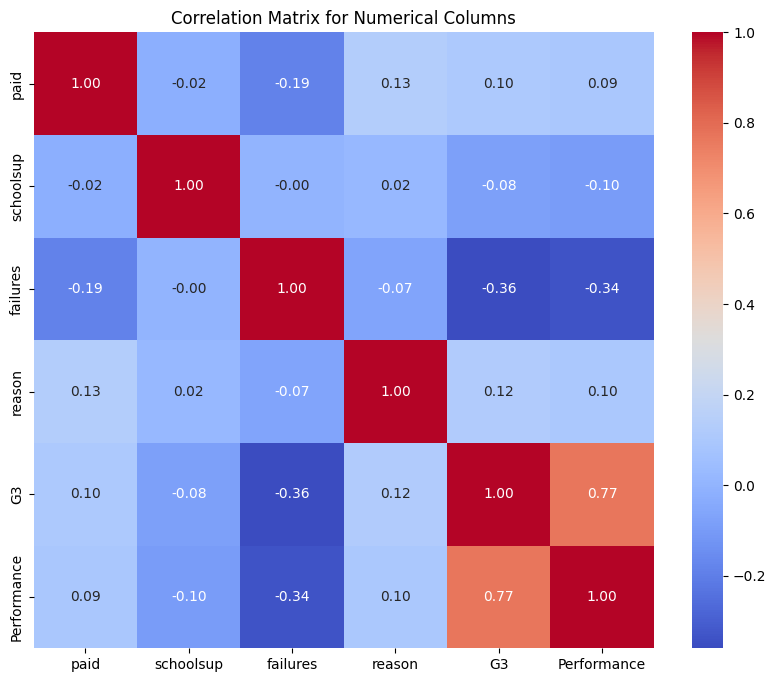

In [9]:
other_cols = [
    'paid', 'schoolsup', 'failures', 'reason', 'G3', 'Performance'
]
other_data = tmp_data[other_cols]

correlation_matrix = other_data.corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for Numerical Columns')
plt.show()

In [10]:
all_attributes = [
    'sex', 'age', 'studytime', 'traveltime', 'activities',
    'nursery', 'higher', 'romantic', 'internet', 'freetime',
    'goout', 'Dalc', 'Walc', 'health', 'absences', 
    'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob',
    'guardian', 'famsup', 'internet', 'famrel',
    'paid', 'schoolsup', 'failures', 'reason'
]
student_attributes = [
    'sex', 'age', 'studytime', 'traveltime', 'activities',
    'nursery', 'higher', 'romantic', 'internet', 'freetime',
    'goout', 'Dalc', 'Walc', 'health', 'absences'
]
family_attributes = [
    'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob',
    'guardian', 'traveltime', 'famsup', 'internet', 'famrel'
]
other_attributes = [
    'paid', 'schoolsup', 'failures', 'reason'
]

## Find the best performing feature(s)
The predictions are generally poor, so we'll highlight only the top five

In [11]:
feature_performance = []

target = 'G3'
# Iterate over each feature
for feature in all_attributes:
    X = tmp_data[[feature]]
    Y = tmp_data[target]

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Perform linear regression
    model = LinearRegression()
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)

    # Evaluate model performance
    mse = mean_squared_error(Y_test, Y_pred)
    r2 = r2_score(Y_test, Y_pred)

    # Store performance metrics
    feature_performance.append({'Feature': feature, 'MSE': mse, 'R2': r2})

performance_df = pd.DataFrame(feature_performance)
top_features = performance_df.sort_values(by='R2', ascending=False).head(5)

print("Top 5 Features Based on R² Score:")
print(top_features)

Top 5 Features Based on R² Score:
     Feature        MSE        R2
28  failures  18.875618  0.079465
18      Medu  19.675840  0.040439
1        age  19.770370  0.035829
19      Fedu  19.846646  0.032109
10     goout  19.862068  0.031357


## Multiple Regression with top features
Let's try multiple regression with these top 5 features

In [12]:
top_features = ['failures', 'Medu', 'age', 'Fedu', 'goout']  # Top features based on single linear regression
target = 'G3'

# Drop missing values
multi_data = tmp_data.copy()
#multi_data = multi_data.dropna(subset=top_features + [target])

X_multi = multi_data[top_features]
Y_multi = multi_data[target]

X_train_multi, X_test_multi, Y_train_multi, Y_test_multi = train_test_split(X_multi, Y_multi, test_size=0.2, random_state=42)

# Train the model
model_multi = LinearRegression()
model_multi.fit(X_train_multi, Y_train_multi)

# Make predictions
Y_pred_multi = model_multi.predict(X_test_multi)

# Evaluate the model
mse_multi = mean_squared_error(Y_test_multi, Y_pred_multi)
r2_multi = r2_score(Y_test_multi, Y_pred_multi)

# Print results
print("Multiple Linear Regression Results:")
print(f"Mean Squared Error (MSE): {mse_multi}")
print(f"R² Score: {r2_multi}")

Multiple Linear Regression Results:
Mean Squared Error (MSE): 17.881046333344525
R² Score: 0.12796853869281433


Use the same set of data for subsequent analysis

In [13]:
all_data = tmp_data.copy()
X = all_data[all_attributes]
y = all_data['G3']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Multi Linear Regression using Backwards Elimination
Let's find the best features for Multi Linear regression using the Backwards Elimination method

In [14]:
X_all = X.copy()
X_all = sm.add_constant(X_all)
y_all = y.copy()

# Fit the initial model with all features
model = sm.OLS(y_all, X_all).fit()
print(model.summary())

# Backward Elimination: Remove the least significant features iteratively
while True:
    p_values = model.pvalues
    max_p = p_values.max()
    if max_p > 0.05:
        feature_to_remove = p_values.idxmax()
        print(f"Removing feature: {feature_to_remove} (p-value: {max_p})")
        X_all = X_all.drop(columns=[feature_to_remove])
        model = sm.OLS(y_all, X_all).fit()
    else:
        break

print("Final Model Summary:")
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     G3   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     4.091
Date:                Sun, 01 Dec 2024   Prob (F-statistic):           8.96e-11
Time:                        16:36:15   Log-Likelihood:                -1105.6
No. Observations:                 395   AIC:                             2271.
Df Residuals:                     365   BIC:                             2391.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.4511      3.987      3.123      0.0

## Other Regression Algorithms with Backwards Elimination
Let's try RandomForest and AdaBoost Regressors


Backward Elimination with RandomForest:

Backward Elimination with AdaBoost:

Best Results for Each Model:

RandomForest:
Best Features: ['sex', 'age', 'studytime', 'traveltime', 'activities', 'nursery', 'higher', 'romantic', 'internet', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'guardian', 'famsup', 'internet', 'famrel', 'paid', 'schoolsup', 'failures', 'reason']
Best R² Score: 0.34092127027787333
Best MSE: 13.514440506329116

AdaBoost:
Best Features: ['sex', 'age', 'studytime', 'nursery', 'romantic', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'guardian', 'famrel', 'paid', 'failures', 'reason']
Best R² Score: 0.164974403631738
Best MSE: 17.122239323576228


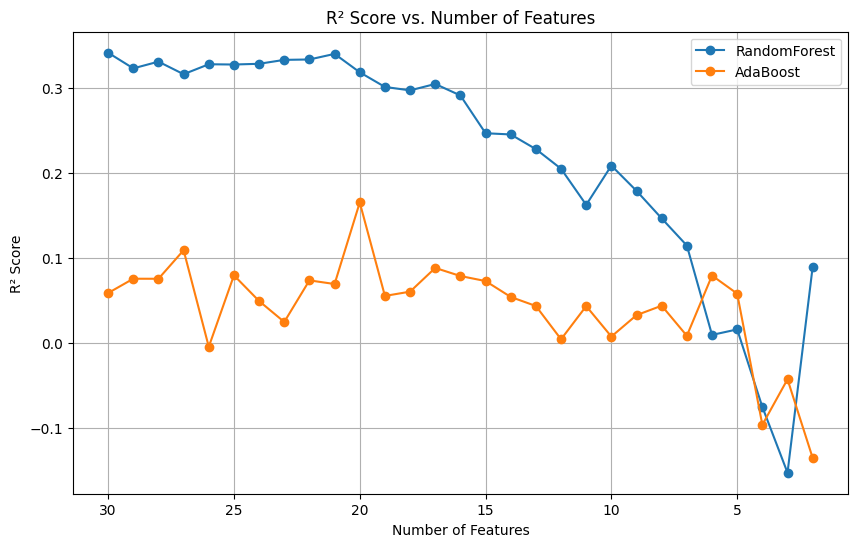

In [15]:
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'AdaBoost': AdaBoostRegressor(random_state=42)
}

best_results = {}
iteration_results = {}

X_train_oa = X_train.copy()
y_train_oa = y_train.copy()
X_test_oa = X_test.copy()
y_test_oa = y_test.copy()

# Backward Elimination Process
for model_name, model in models.items():
    print(f"\nBackward Elimination with {model_name}:")

    remaining_features = all_attributes[:]
    best_r2 = -float('inf')
    best_model_features = None
    best_model_mse = None
    
    iteration_results[model_name] = {'r2_scores': [], 'num_features': []}
    
    while len(remaining_features) > 1:
        model.fit(X_train_oa[remaining_features], y_train_oa)

        Y_pred = model.predict(X_test_oa[remaining_features])
        mse = mean_squared_error(y_test_oa, Y_pred)
        r2 = r2_score(y_test_oa, Y_pred)

        iteration_results[model_name]['r2_scores'].append(r2)
        iteration_results[model_name]['num_features'].append(len(remaining_features))

        # Update the best model if this iteration is better
        if r2 > best_r2:
            best_r2 = r2
            best_model_features = remaining_features[:]
            best_model_mse = mse

        importances = model.feature_importances_
        least_important_feature = remaining_features[importances.argmin()]

        # Remove the least important feature
        remaining_features.remove(least_important_feature)
    
    best_results[model_name] = {
        'Features': best_model_features,
        'R² Score': best_r2,
        'MSE': best_model_mse
    }

print("\nBest Results for Each Model:")
for model_name, result in best_results.items():
    print(f"\n{model_name}:")
    print(f"Best Features: {result['Features']}")
    print(f"Best R² Score: {result['R² Score']}")
    print(f"Best MSE: {result['MSE']}")

plt.figure(figsize=(10, 6))
for model_name, results in iteration_results.items():
    plt.plot(
        results['num_features'],
        results['r2_scores'],
        label=model_name,
        marker='o'
    )

plt.gca().invert_xaxis()
plt.title("R² Score vs. Number of Features")
plt.xlabel("Number of Features")
plt.ylabel("R² Score")
plt.legend()
plt.grid(True)
plt.show()

## Classification Algorithms
Let's try some classification algorithms

In [16]:
classifier_data = tmp_data.copy()
X_class = classifier_data[all_attributes]
y_class = classifier_data['Performance']

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42)


Logistic Regression Results:
Accuracy: 0.73
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.41      0.51        27
           1       0.75      0.90      0.82        52

    accuracy                           0.73        79
   macro avg       0.72      0.66      0.66        79
weighted avg       0.73      0.73      0.71        79



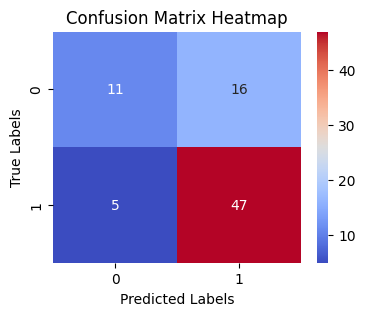


Random Forest Results:
Accuracy: 0.70
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.26      0.37        27
           1       0.71      0.92      0.80        52

    accuracy                           0.70        79
   macro avg       0.67      0.59      0.58        79
weighted avg       0.68      0.70      0.65        79



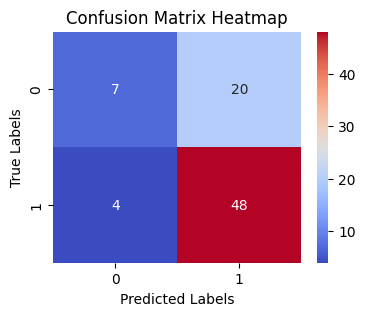


AdaBoost Results:
Accuracy: 0.73
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.37      0.49        27
           1       0.74      0.92      0.82        52

    accuracy                           0.73        79
   macro avg       0.73      0.65      0.65        79
weighted avg       0.73      0.73      0.71        79



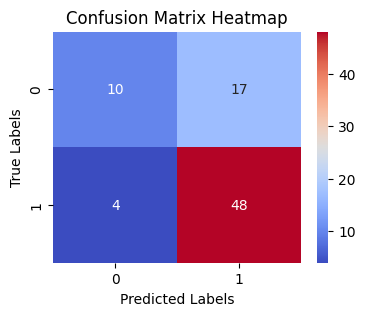


KNN Results:
Accuracy: 0.71
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.26      0.38        27
           1       0.71      0.94      0.81        52

    accuracy                           0.71        79
   macro avg       0.71      0.60      0.59        79
weighted avg       0.71      0.71      0.66        79



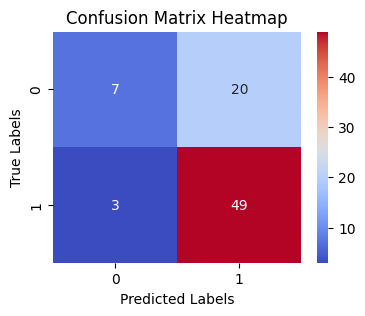


Comparison of Classifier Accuracies:
Logistic Regression: 0.73
Random Forest: 0.70
AdaBoost: 0.73
KNN: 0.71


In [17]:
models = [
    ("Logistic Regression", Pipeline([
        ('scaler', StandardScaler()), 
        ('logistic', LogisticRegression(max_iter=1000))
    ])),
    ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42)),
    ("AdaBoost", AdaBoostClassifier(n_estimators=50, random_state=42, algorithm='SAMME')),
    ("KNN", KNeighborsClassifier(n_neighbors=5))
]

results = {}

# Loop through each model
for name, model in models:
    print(f"\n{name} Results:")
    
    model.fit(X_train_class, y_train_class)
    
    y_pred = model.predict(X_test_class)
    
    accuracy = accuracy_score(y_test_class, y_pred)
    results[name] = accuracy

    cm = confusion_matrix(y_test_class, y_pred)
    
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:\n", classification_report(y_test_class, y_pred))
    
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=np.unique(y_test_class), yticklabels=np.unique(y_test_class))
    plt.title("Confusion Matrix Heatmap")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

print("\nComparison of Classifier Accuracies:")
for model, accuracy in results.items():
    print(f"{model}: {accuracy:.2f}")

## Compare Classification vs Prediction with 'Performance' as the Target variable
For completeness, let's test Regression with 'Performance' as the Target variable


Backward Elimination with RandomForest:

Backward Elimination with AdaBoost:

Backward Elimination with LinearRegression:

Best Results for Each Model:

RandomForest:
Best Features: ['sex', 'age', 'studytime', 'traveltime', 'activities', 'nursery', 'romantic', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'famsize', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'guardian', 'famsup', 'failures', 'reason']
Best R² Score: 0.1840717948717946
Best MSE: 0.18355443037974686

AdaBoost:
Best Features: ['age', 'goout', 'Walc', 'absences', 'schoolsup', 'failures', 'reason']
Best R² Score: 0.16784492622201896
Best MSE: 0.18720489081626102

LinearRegression:
Best Features: ['sex', 'age', 'studytime', 'activities', 'nursery', 'higher', 'internet', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'internet', 'famrel', 'paid', 'schoolsup', 'failures', 'reason']
Best R² Score: 0.12484651342795416
Best MSE: 0.19687798351981287


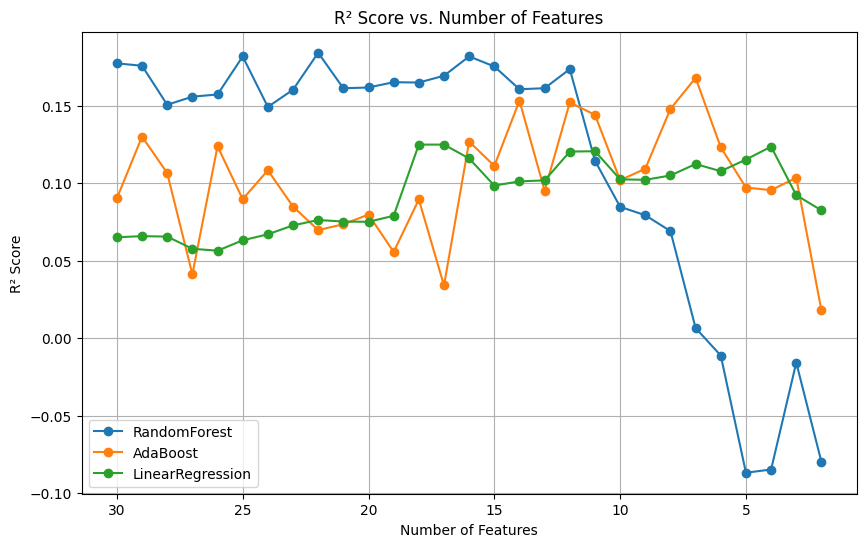

In [18]:
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'LinearRegression': LinearRegression()
}

best_results = {}
iteration_results = {}

X_train_class_oa = X_train_class.copy()
y_train_class_oa = y_train_class.copy()
X_test_class_oa = X_test_class.copy()
y_test_class_oa = y_test_class.copy()

# Backward Elimination Process
for model_name, model in models.items():
    print(f"\nBackward Elimination with {model_name}:")

    remaining_features = all_attributes[:]
    best_r2 = -float('inf')
    best_model_features = None
    best_model_mse = None

    iteration_results[model_name] = {'r2_scores': [], 'num_features': []}

    while len(remaining_features) > 1:
        model.fit(X_train_class_oa[remaining_features], y_train_class_oa)

        Y_pred = model.predict(X_test_class_oa[remaining_features])
        mse = mean_squared_error(y_test_class_oa, Y_pred)
        r2 = r2_score(y_test_class_oa, Y_pred)

        iteration_results[model_name]['r2_scores'].append(r2)
        iteration_results[model_name]['num_features'].append(len(remaining_features))

        if r2 > best_r2:
            best_r2 = r2
            best_model_features = remaining_features[:]
            best_model_mse = mse

        if model_name in ['RandomForest', 'AdaBoost']:
            importances = model.feature_importances_
        elif model_name == 'LinearRegression':
            logger_val = 1
            importances = np.abs(model.coef_)

        min_loc = np.argmin(importances)
        if len(remaining_features) > min_loc:
            least_important_feature = remaining_features[min_loc]
            remaining_features.remove(least_important_feature)
        else:
            print("Only one feature remaining, stopping elimination.")
            break

    best_results[model_name] = {
        'Features': best_model_features,
        'R² Score': best_r2,
        'MSE': best_model_mse
    }

print("\nBest Results for Each Model:")
for model_name, result in best_results.items():
    print(f"\n{model_name}:")
    print(f"Best Features: {result['Features']}")
    print(f"Best R² Score: {result['R² Score']}")
    print(f"Best MSE: {result['MSE']}")

plt.figure(figsize=(10, 6))
for model_name, results in iteration_results.items():
    plt.plot(
        results['num_features'],
        results['r2_scores'],
        label=model_name,
        marker='o'
    )

plt.gca().invert_xaxis()
plt.title("R² Score vs. Number of Features")
plt.xlabel("Number of Features")
plt.ylabel("R² Score")
plt.legend()
plt.grid(True)
plt.show()

## Step 1 - Gather data
For this project, we gathered data from https://archive.ics.uci.edu/dataset/320/student+performance. While the original dataset contains both data for Portuguese and Mathematics student performances, we used only the mathematics dataset for this project.


## Step 2 - Identify a Supervised Machine Learning Problem
Our goal was to determine if there are any Supervised Learning models that can be used to predict student performance when given the features available in this dataset.

## Step 3 - Exploratory Data Analysis
We observed that the dataset had 33 features, which is a high number for Supervised learning algorithms. We noticed that there were a number of Yes/No and other categorical columns, so we converted these to numerical datatypes. We also ensured that there were no null/empty cells.
We also we included a classification column for Performance, to enable classification of student performance as either pass or fail. In future iterations, we can expand the classification to different grades of performance such as 'Excellent, Pass, Fail, Very Poor'.

We made the decision to exclude the G1 and G2 columns from our models since they are 1st and 2nd test results which directly contribute to the G3, which is the student's final performance.

Finally, we generated a correlation map to visually inspect the correlations between the features and our target 'G3' (or 'Performance') feature. With the correlation map, we observed that there was very poor correlation between any of the features individually and the target feature.

## Step 4 - Analysis
We performed several analysis over this dataset.
1. First, we trained models for all the features in the dataset against the target. This performed very poorly as expected from the correlation matrix. The best performing single predictor was the previous failures of the student, which is reasonable because a student that has failed the class prior would be studying the material for another year. This had an R Squared of 0.07947 and MSE of 18.8756
2. Using the top 5 features from the previous step, we performed a Multiple Linear Regression and got a better predictor for final student result, although still very poor with an R Squared of 0.1280 and a MSE of 17.8810
3. We decided to move faster by automating the process and opted to use the Backward Elimation algorithm to try to determine the optimal feature set to use for our model. We observed that the R Squared of the model that contained all the features actually performed the best at 0.245.
4. For completeness, we tried both RandomForest and AdaBoost regression algorithms, and observed RandomForest as the best performing algorithm, using Backwards Elimination for this dataset with an R Squared value of 0.3409.
5. Using the same method as in Item 4 above, we compared four classification algorithms, Logistic Regression, Random Forest, AdaBoost and kNN. These classification algorithms performed relatively good, with all of them having an accuracy equal or over 0.70. They were all very close, with the highest at 0.73.
6. Finally, we trained some Regression models to predict student performance against the 'Performance' column that was used for the classification investigation above. These also performed poorly, suggesting that the model struggles to capture any relationship to 'Performance'